# Ultralytics Classifier (Portafoglio, Tazza, Cassa)


Set up runtime to use GPU

## Get Dataset online

In [4]:
# Get the dataset here: https://drive.google.com/file/d/1jf0gXPgeG9ROCXY6CzT7krLJksSQNRDy/view?usp=sharing
# Downlaod the dataset and rename it --> dataset.tar.gz
# Import in drive

In [ ]:
!tar -xf dataset.tar.gz

> Dataset structure


```
dataset
    data.yaml
    train
        portafoglio
        tazza
        cassa
    val
        portafoglio
        tazza
        cassa
    test
        portafoglio
        tazza
        cassa
```



## Training

In [92]:
# Create training config file
dataset = "/content/dataset"
import yaml
labels_name = ["cassa","portafoglio","tazza"]
data = {
    "train": f"{dataset}/train",
    "val":   f"{dataset}/val",
    "test":  f"{dataset}/test",
    "nc": len(labels_name),
    "names": labels_name,
}
# Create and write to the YAML file
yaml_file_path = "dataset/data.yaml"
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, sort_keys=False)


In [ ]:
# Install ultralytics
!pip install ultralytics

In [94]:
# remove dataset if available. Each training has to be unique
!rm -rf tmp_training

In [ ]:
# train
from ultralytics import YOLO
model = YOLO("yolov8n-cls.pt", task="classify")
results = model.train(data="/content/dataset", epochs=30, imgsz=640,batch=4, project="/content/tmp_training")


## Inference Pipeline: Test the model on webcam

In [67]:
import torch
import numpy as np

class Yolov8Inference:
    def __init__(self, model_path, gpu=False):
        self.model = YOLO(model_path)
        self.device = torch.device("cpu")
        if gpu:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
                print(f"Model will run on GPU: {torch.cuda.get_device_name(0)}")
            else:
                print("Model will run on CPU, because GPU is not available")
        else:
            print("Model will run on CPU")
        self.labels = self.model.names

    def predict(self, im):

        # im has to be numpy array
        # start = time.time()
        res = self.model.predict(im, imgsz=640, device=self.device, conf=0.01, iou=0.01, verbose=False)
        # end = time.time()
        # print(f"Model inference: {end-start:2f}s")

        #print(res[0].probs)
        names = res[0].names
        scores = res[0].probs.data.cpu().numpy()

        im_draw = im.copy()
        idx = np.argmax(scores)
        score = scores[idx]
        cv2.putText(im_draw, f"{names[idx]}: {score:.2f}", (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255, 0, 0), 1)

        return im_draw

In [85]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Model will run on CPU


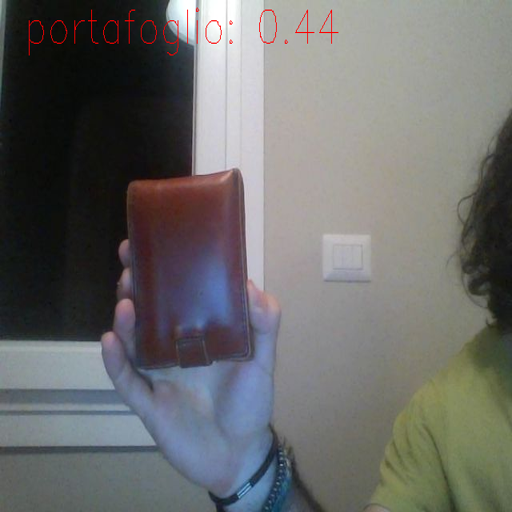

In [89]:
from PIL import Image
model = Yolov8Inference("/content/tmp_training/train/weights/best.pt")
im = cv2.imread("photo.jpg", cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im_draw = model.predict(im)
display(Image.fromarray(im_draw).resize((512,512)))
#break

## Extra: Create dataset offline

```python
#---------------------------
# Acquire Image Press (s)
#---------------------------
# pip install opencv-python

import cv2
from datetime import datetime
import numpy as np

# Load Model
key = cv2. waitKey(1)
webcam = cv2.VideoCapture(0)
while True:
    check, frame = webcam.read()
    cv2.imshow("Capturing", frame)
    key = cv2.waitKey(1)
    if key == ord('s'):
        ora = datetime.now()
        timestamp = ora.strftime("%Y-%m-%d_%H-%M-%S")
        nome_file = f"{timestamp}.png"
        cv2.imwrite(filename=nome_file, img=frame)
        print("Image saved!")
    elif key == ord('q'):
        webcam.release()
        cv2.destroyAllWindows()
        break  
```

```python
# ------------------------------
# Run inference real time locally
# -----------------------------
# pip install ultralytics

import cv2
from datetime import datetime
import numpy as np
from ultralytics import YOLO

class Yolov8Inference:
    def __init__(self, model_path):
        self.model = YOLO(model_path)
        self.labels = self.model.names
    def predict(self, im):
        res = self.model.predict(im, imgsz=640, conf=0.6, iou=0.01, verbose=False)
        names = res[0].names
        scores = res[0].probs.data.cpu().numpy()
        im_draw = im.copy()
        idx = np.argmax(scores)
        score = scores[idx]
        cv2.putText(im_draw, f"{names[idx]}: {score:.2f}", (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255, 0, 0), 1)
        return im_draw

# Load Model
model = Yolov8Inference("models/best.pt")
key = cv2. waitKey(1)
webcam = cv2.VideoCapture(0)
while True:
    check, frame = webcam.read()
    im_draw = model.predict(frame)
    cv2.imshow("Capturing", im_draw)
    key = cv2.waitKey(1)
    if key == ord('s'):
        ora = datetime.now()
        timestamp = ora.strftime("%Y-%m-%d_%H-%M-%S")
        nome_file = f"{timestamp}.png"
        cv2.imwrite(filename=nome_file, img=frame)
        print("Image saved!")
    elif key == ord('q'):
        webcam.release()
        cv2.destroyAllWindows()
        break  
```